## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Install Required Libraries

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pycaret --user

### Loading data

In [1]:
import pandas as pd
import time

# Define path where input files are located
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'

# Input filename
filename = path + 'Retails_ALL_CY11_CY22.xlsx'
external_filename = path + 'External_indicators_weekly.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)
df_external = pd.concat(pd.read_excel(external_filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 152.830142 seconds.


### Preprocessing data

In [2]:
# Get only Finland orders
df = df[df.RetailCountry == 'FIN']

# Remove duplicates by "orderNumber"
df.drop_duplicates(subset=['orderNumber'], keep='last', inplace=True)

# Remove unnecessary columns
df.drop(['vehOrderClassCode', 'RetailNSC', 'NSCModelGroupCode',
       'ReportingModelGroup', 'FleetCode', 'DealerCodeRetail',
       'orderCreatedDate', 'RetailCountry', 'ModelGroup',
       'EndItem', 'EIColourCode', 'DealerDeliveryAddrNoRetail',
       'FinancialOwnerCategoryCurrent', 'FinancialOwnerCategoryNext',
       'RetailCount', 'Month'], axis=1, inplace=True)

In [3]:
# Convert RetailDate to date
df['RetailDate'] = pd.to_datetime(df['RetailDate'], dayfirst=True)
# Get year of the ReailDate
df['year'] = pd.DatetimeIndex(df['RetailDate']).year
# Get month of the RetailDate
df['month'] = pd.DatetimeIndex(df['RetailDate']).month
# Get week of the year
df['week_of_year'] = df.RetailDate.apply(lambda x: x.weekofyear)
df["week_of_year"] = df.week_of_year.map("{:02}".format)

In [4]:
# Preview dataframe
df

orderNumber          RetailDate  year  month week_of_year
2       NNE0161192 2011-01-03 06:25:49  2011      1           01
3       NNE0146363 2011-01-03 06:28:35  2011      1           01
4       NNE0147851 2011-01-03 06:30:20  2011      1           01
5       NNE0144683 2011-01-03 06:32:19  2011      1           01
6       NNE0151309 2011-01-03 06:32:52  2011      1           01
...            ...                 ...   ...    ...          ...
465317  NNE0646993 2022-08-15 12:17:33  2022      8           33
465346  NNE0646781 2022-08-08 08:39:41  2022      8           32
465350  NNE0646864 2022-08-12 09:36:53  2022      8           32
465351  NNE0646872 2022-08-11 08:11:52  2022      8           32
465352  NNE0646875 2022-08-10 09:41:23  2022      8           32

[76849 rows x 5 columns]

In [5]:
# Create a column "Period" with yaar-week
df["Period"] = df['year'].astype(str) + "-" + df["week_of_year"].astype(str)

# Generating index by date, grouping by and counting
df.drop(df[df.Period > '2022-31'].index, inplace=True)
df = df.groupby(['Period']).size().reset_index(name='Orders')
df = df.set_index(['Period'])

In [6]:
df

Orders
Period         
2011-01     215
2011-02     196
2011-03     171
2011-04     179
2011-05     220
...         ...
2022-27      16
2022-28      20
2022-29      23
2022-30      57
2022-31      30

[606 rows x 1 columns]

In [7]:
# Set Period as index
df_external = df_external.set_index(['Period'])

In [8]:
# Remove unnecessary columns
df_external.drop(['Reference_Date'], axis=1, inplace=True)

In [9]:
# Merge both dataframes
data = pd.concat([df,df_external], axis=1)

In [10]:
# Preview dataframe
data

Orders   CCI     CPI   CoL  Avg_fuel_price    TIV  \
Period                                                       
2011-01     215   0.3  101.78  1783          1.3575  14993   
2011-02     196   0.3  101.78  1783          1.3575  14993   
2011-03     171   0.3  101.78  1783          1.3575  14993   
2011-04     179   0.3  101.78  1783          1.3575  14993   
2011-05     220   0.3  101.78  1783          1.3575  14993   
...         ...   ...     ...   ...             ...    ...   
2022-27      16 -15.9  123.96  2172          2.2000   6101   
2022-28      20 -15.9  123.96  2172          2.2000   6101   
2022-29      23 -15.9  123.96  2172          2.2000   6101   
2022-30      57 -15.9  123.96  2172          2.2000   6101   
2022-31      30 -14.9  124.05  2173          2.0200   8163   

         Unemployment_rate_%  
Period                        
2011-01                  8.6  
2011-02                  8.6  
2011-03                  8.6  
2011-04                  8.6  
2011-05                  8.6  
...                      ...  
2022-27                  6.6  
2022-28                  6.6  
2022-29                  6.6  
2022-30                  6.6  
2022-31                  6.7  

[606 rows x 7 columns]

In [11]:
# Save data to Excel so we don't need to run previous steps every time
data.to_excel("output_weekly.xlsx")  

### ** Execution can start from here **

In [28]:
import pandas as pd

# Load file into a pandas dataframe
file = 'D:/Git_Projects/5. Master_thesis/output_weekly.xlsx'
data = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)
data = data.set_index("Period")

In [29]:
# Data statistics
data.describe()

Orders         CCI         CPI          CoL  Avg_fuel_price  \
count  606.000000  606.000000  606.000000   606.000000      606.000000   
mean   126.442244   -3.324752  110.243746  1931.361386        1.412471   
std    130.153346    4.598215    4.024910    70.554613        0.197450   
min      3.000000  -15.900000  101.780000  1783.000000        1.115000   
25%     38.000000   -5.975000  108.290000  1897.000000        1.292500   
50%     76.500000   -3.700000  109.580000  1920.000000        1.397500   
75%    159.000000    0.100000  112.410000  1969.000000        1.472500   
max    727.000000    6.800000  124.050000  2173.000000        2.407500   

                TIV  Unemployment_rate_%  
count    606.000000           606.000000  
mean   10222.282178             8.080858  
std     2338.190361             1.309430  
min     4286.000000             5.400000  
25%     8897.000000             7.000000  
50%     9964.000000             8.000000  
75%    11220.000000             9.000000  
max    25629.000000            11.700000

In [30]:
data.isna().sum()

Orders                 0
CCI                    0
CPI                    0
CoL                    0
Avg_fuel_price         0
TIV                    0
Unemployment_rate_%    0
dtype: int64

### Logarithmic Scale?

In [31]:
import numpy as np
data['Orders'] = np.log(data['Orders'])

### Plotting data

array([[<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
       [<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
       [<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
       [<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
       [<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>],
       [<AxesSubplot:xlabel='Period'>, <AxesSubplot:xlabel='Period'>]],
      dtype=object)

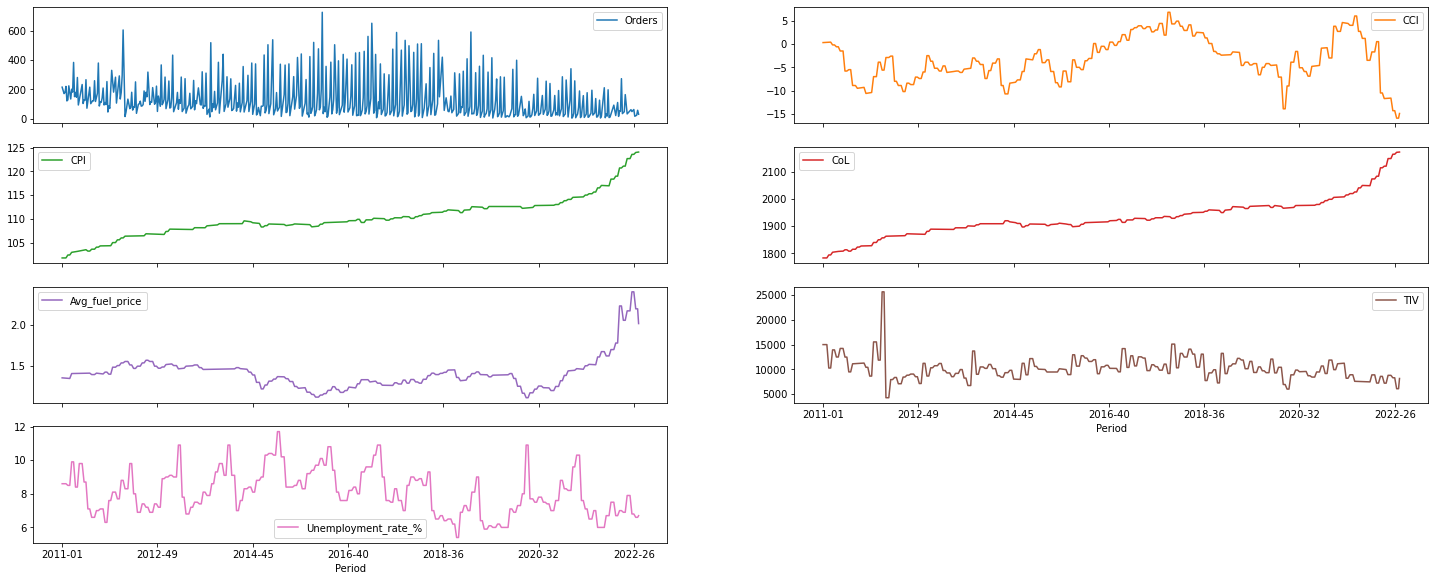

In [32]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams["figure.figsize"] = [25, 15]
data.plot(legend=True, subplots=True, layout=(6,2))

In [33]:
data

Orders   CCI     CPI   CoL  Avg_fuel_price    TIV  \
Period                                                       
2011-01     215   0.3  101.78  1783          1.3575  14993   
2011-02     196   0.3  101.78  1783          1.3575  14993   
2011-03     171   0.3  101.78  1783          1.3575  14993   
2011-04     179   0.3  101.78  1783          1.3575  14993   
2011-05     220   0.3  101.78  1783          1.3575  14993   
...         ...   ...     ...   ...             ...    ...   
2022-27      16 -15.9  123.96  2172          2.2000   6101   
2022-28      20 -15.9  123.96  2172          2.2000   6101   
2022-29      23 -15.9  123.96  2172          2.2000   6101   
2022-30      57 -15.9  123.96  2172          2.2000   6101   
2022-31      30 -14.9  124.05  2173          2.0200   8163   

         Unemployment_rate_%  
Period                        
2011-01                  8.6  
2011-02                  8.6  
2011-03                  8.6  
2011-04                  8.6  
2011-05                  8.6  
...                      ...  
2022-27                  6.6  
2022-28                  6.6  
2022-29                  6.6  
2022-30                  6.6  
2022-31                  6.7  

[606 rows x 7 columns]

In [19]:
import numpy as np

def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [34]:
data['Orders'] = fft_denoiser(data['Orders'].to_numpy(), 10, False).tolist()

In [35]:
data

Orders   CCI     CPI   CoL  Avg_fuel_price    TIV  \
Period                                                                     
2011-01  215.253816+0.000000j   0.3  101.78  1783          1.3575  14993   
2011-02  196.042075-0.000000j   0.3  101.78  1783          1.3575  14993   
2011-03  170.803403-0.000000j   0.3  101.78  1783          1.3575  14993   
2011-04  178.759228-0.000000j   0.3  101.78  1783          1.3575  14993   
2011-05  219.939515+0.000000j   0.3  101.78  1783          1.3575  14993   
...                       ...   ...     ...   ...             ...    ...   
2022-27   15.972910-0.000000j -15.9  123.96  2172          2.2000   6101   
2022-28   19.732872-0.000000j -15.9  123.96  2172          2.2000   6101   
2022-29   22.744036-0.000000j -15.9  123.96  2172          2.2000   6101   
2022-30   56.987946+0.000000j -15.9  123.96  2172          2.2000   6101   
2022-31   30.232641-0.000000j -14.9  124.05  2173          2.0200   8163   

         Unemployment_rate_%  
Period                        
2011-01                  8.6  
2011-02                  8.6  
2011-03                  8.6  
2011-04                  8.6  
2011-05                  8.6  
...                      ...  
2022-27                  6.6  
2022-28                  6.6  
2022-29                  6.6  
2022-30                  6.6  
2022-31                  6.7  

[606 rows x 7 columns]

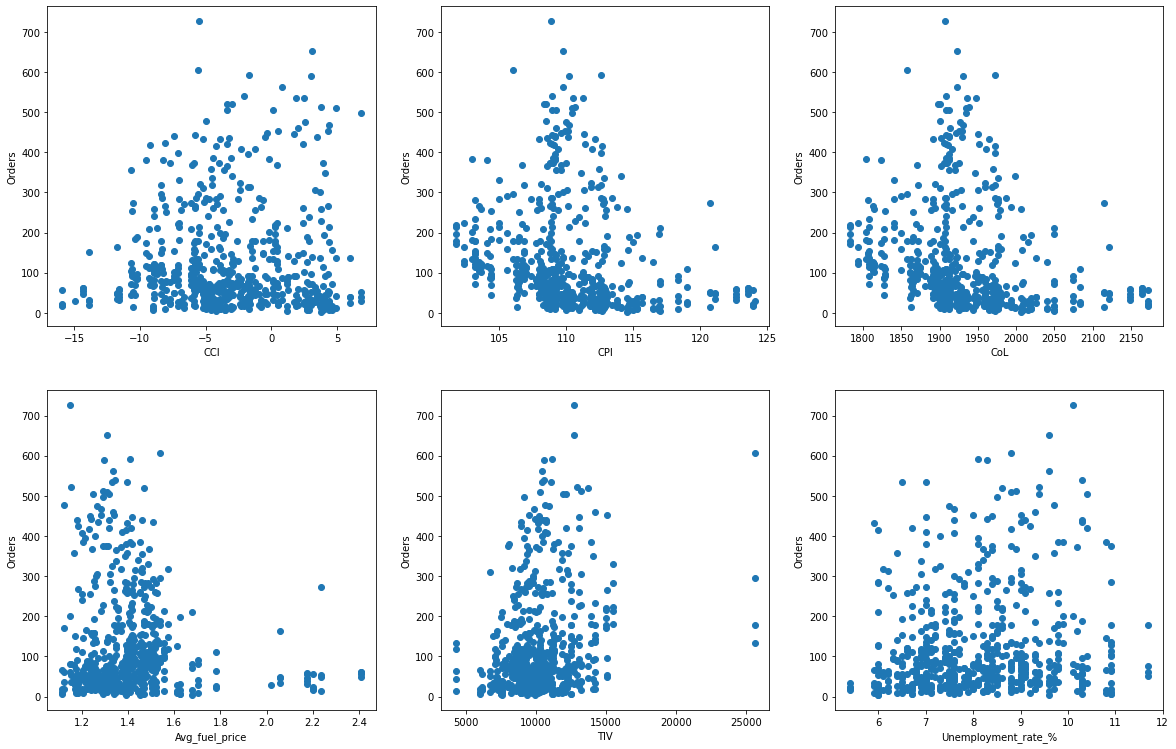

In [50]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):

    dep_var = 'Orders'                          # Dependant variable
    ind_var = df.loc[:, df.columns != 'Orders'] # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(20,20))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(data,3)

<AxesSubplot:>

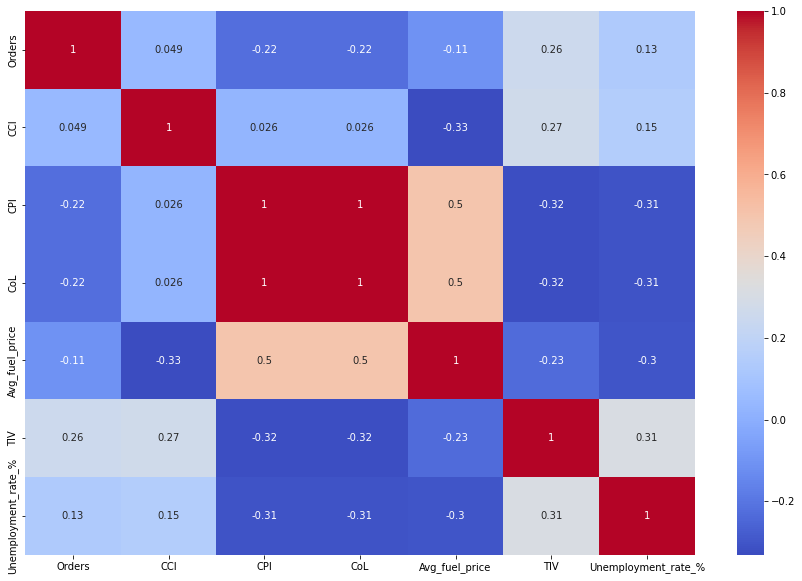

In [51]:
# Import seaborn
import seaborn as sns

# Plot the correlations as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2g')

### Pandas Profiling

https://github.com/ydataai/pandas-profiling

In [7]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Pandas Profiling Report")

In [8]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


In [52]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((484, 6), (122, 6))

### Pycaret Analysis

https://pycaret.gitbook.io/docs/

In [10]:
from pycaret.regression import *

dataset = data
data_pycaret = dataset.sample(frac=0.8, random_state=42)
data_unseen = dataset.drop(data_pycaret.index)

data_pycaret.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data_pycaret.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

# Initial setup
model_setup=setup(data=data_pycaret,target='Orders')

# Model training and selection
best = compare_models()

# Analyze best model
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
et = create_model('et') # Extra Trees Regressor

In [20]:
br = create_model('br') # Bayesian Ridge

In [21]:
gbr = create_model('gbr') # Gradient Boosting Regressor

In [22]:
rf = create_model('rf') # Random Forest Regressor

In [23]:
lightgbm = create_model('lightgbm') # Light Gradient Boosting Machine

In [11]:
xgb = create_model('xgboost') 

In [12]:
tuned_xgb = tune_model(xgb) # Extreme Gradient Boosting

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

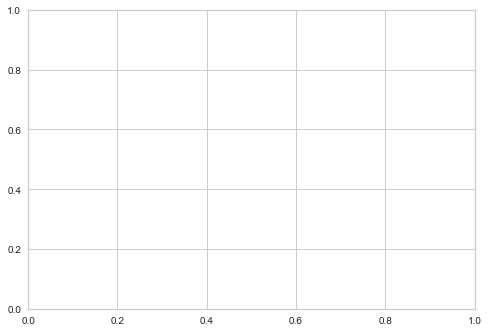

In [13]:
evaluate_model(tuned_xgb)

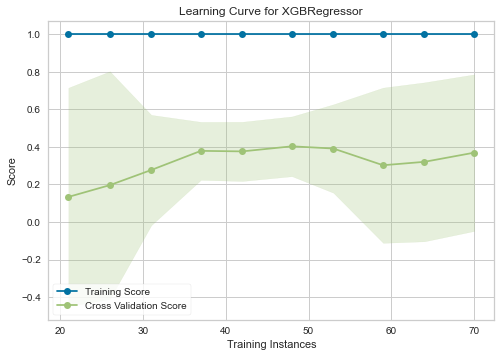

In [14]:
#+-----------------------------+-------------+
#|            Name             |    Plot     |
#+-----------------------------+-------------+
#| Residuals Plot              | ‘residuals’ |
#| Prediction Error Plot       | ‘error’     |
#| Cooks Distance Plot         | ‘cooks’     |
#| Recursive Feature Selection | ‘rfe’       |
#| Learning Curve              | ‘learning’  |
#| Validation Curve            | ‘vc’        |
#| Manifold Learning           | ‘manifold’  |
#| Feature Importance          | ‘feature’   |
#| Model Hyperparameter        | ‘parameter’ |
#+-----------------------------+-------------+

plot_model(tuned_xgb, plot ='learning')

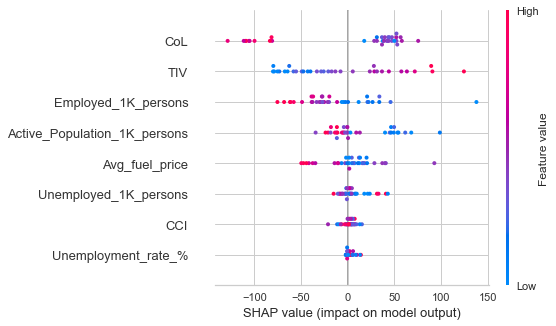

In [15]:
interpret_model(tuned_xgb)

In [16]:
predict_model(tuned_xgb)

CCI     CoL  Avg_fuel_price      TIV  Active_Population_1K_persons  \
0   -2.5  1881.0          1.5200   8657.0                        2621.0   
1    4.9  1935.0          1.3075  10314.0                        2669.0   
2    2.5  1948.0          1.3975  10453.0                        2780.0   
3   -8.9  1815.0          1.3975  11122.0                        2675.0   
4   -3.4  1902.0          1.3475   9467.0                        2704.0   
5    0.5  2084.0          1.7825   7239.0                        2755.0   
6   -3.2  1902.0          1.2700   8904.0                        2627.0   
7    4.4  1931.0          1.2825   9838.0                        2649.0   
8    4.3  1929.0          1.3375  15092.0                        2653.0   
9   -5.4  1894.0          1.4600   8249.0                        2619.0   
10  -0.3  1921.0          1.2350  10192.0                        2599.0   
11  -5.5  1808.0          1.4150   9490.0                        2732.0   
12  -4.5  1976.0          1.3500   9289.0                        2663.0   
13  -2.6  1864.0          1.5150   7942.0                        2762.0   
14   3.0  1931.0          1.2975  10542.0                        2644.0   
15   4.0  2020.0          1.5225   8914.0                        2767.0   
16  -7.7  1910.0          1.3025   7977.0                        2609.0   
17   2.7  2041.0          1.6125   7556.0                        2734.0   
18  -6.6  1975.0          1.3900  10495.0                        2698.0   
19  -9.2  1911.0          1.2300  10127.0                        2646.0   
20   4.1  1946.0          1.3850  14077.0                        2783.0   
21  -1.8  1912.0          1.2150   9125.0                        2697.0   
22  -8.2  1913.0          1.3925   8037.0                        2614.0   
23  -1.7  2074.0          1.7025   8892.0                        2739.0   
24  -5.8  1908.0          1.2375   9961.0                        2584.0   
25   2.6  1927.0          1.2650  10933.0                        2672.0   
26  -4.6  1980.0          1.2525   9473.0                        2671.0   
27  -5.8  1892.0          1.4675  11191.0                        2751.0   
28  -2.4  1950.0          1.3225  13231.0                        2662.0   
29   4.6  2008.0          1.4625  11246.0                        2898.0   
30  -4.6  1969.0          1.4100  12075.0                        2705.0   
31  -9.3  1827.0          1.4050  11270.0                        2606.0   
32 -10.7  1920.0          1.4625   9334.0                        2626.0   
33  -4.8  1977.0          1.2025   8447.0                        2687.0   

    Employed_1K_persons  Unemployed_1K_persons  Unemployment_rate_%  Orders  \
0                2386.0                  235.0                  9.0     554   
1                2434.0                  234.0                  8.8     697   
2                2599.0                  181.0                  6.5     678   
3                2499.0                  177.0                  6.6     689   
4                2477.0                  227.0                  8.4     578   
5                2570.0                  185.0                  6.7     223   
6                2357.0                  270.0                 10.3     694   
7                2449.0                  201.0                  7.6     763   
8                2414.0                  239.0                  9.0     662   
9                2407.0                  212.0                  8.1     601   
10               2381.0                  218.0                  8.4     662   
11               2538.0                  194.0                  7.1     530   
12               2479.0                  185.0                  6.9     462   
13               2492.0                  270.0                  9.8     411   
14               2425.0                  219.0                  8.3     762   
15               2588.0                  179.0                  6.5     250   
16               2379.0             

### Data split

In [53]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((484, 6), (122, 6))

### Data Normalization

In [54]:
from sklearn.preprocessing import MinMaxScaler

max_min_scaler = MinMaxScaler()
X_train_mm_scaled = max_min_scaler.fit_transform(X_train)
X_test_mm_scaled = max_min_scaler.transform(X_test)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_std_scaled = std_scaler.fit_transform(X_train)
X_test_std_scaled = std_scaler.transform(X_test)

### Scoring function

In [55]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt

metrics = pd.DataFrame()

def scoring(model_name, model, test_features, test_labels):
    
    # Make predictions
    predictions = model.predict(test_features)
    
    # Calculate metrics
    mae = mean_absolute_error(test_labels, predictions)             # MAE
    mse = mean_squared_error(test_labels, predictions)              # MSE
    rmse = math.sqrt(mse)                                           # RMSE
    msle = mean_squared_log_error(test_labels, predictions)         # R2
    rmsle = math.sqrt(msle)                                         # MSLE
    r2 = r2_score(test_labels, predictions)                         # RMSLE
    errors = abs(predictions - test_labels)                         
    mape = 100 * np.mean(errors / test_labels)                      # MAPE
    accuracy = 100 - mape                                           # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, msle, rmsle, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2', 
                    'Mean Squared Log Error', 
                    'Root Mean Squared Log Error', 
                    'Mean Absolute Percentage Error', 
                    'Accuracy']
    
    # Print metrics    
    print(model_name, 'Model Performance:')                         # Model name
    print('Mean Absolute Error: {:0.4f}.'.format(mae))              # MAE
    print('Mean Squared Error: {:0.4f}.'.format(mse))               # MSE
    print('Root Mean Squared Error: {:0.4f}.'.format(rmse))         # RMSE  
    print('R^2 Score = {:0.4f}.'.format(r2))                        # R2
    print('Mean Squared Log Error: {:0.4f}.'.format(msle))          # MSLE
    print('Root Mean Squared Log Error: {:0.4f}.'.format(rmsle))    # RMSLE
    print('Mean Absolute Percentage Error: {:0.4f}.'.format(mape))  # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                  # Accuracy

    # Plot Actual values vs predicted values
    plt.figure(figsize=(12, 8))    

    df = pd.DataFrame(y_test)    
    
    plt.plot(df.index,y_test, c='g', label="Actual values")                         # Acutal values
    plt.plot(df.index,predictions, c='b', label="Predicted values", ls='--')        # Predicted values    
    plt.title('Actual vs Predictions with ' + model_name)                           # Title
    plt.xlabel('Date')                                                              
    plt.ylabel('Orders')                                                             
    plt.legend()
    plt.show()        

### XGBoost (Extreme Gradient Boosting)

#### Baseline

XGboost version: 1.7.2
XGBRegressor Model Performance:
Mean Absolute Error: 79.4438.
Mean Squared Error: 7456.9665.
Root Mean Squared Error: 86.3537.
R^2 Score = -0.3735.
Mean Squared Log Error: 1.9397.
Root Mean Squared Log Error: 1.3927.
Mean Absolute Percentage Error: 370.9714.
Accuracy = -270.97%.


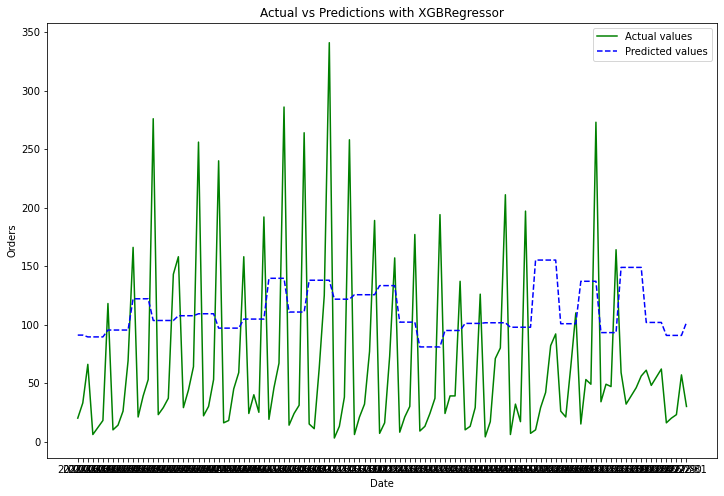

In [60]:
import xgboost as xgb

# Check xgboost version
print("XGboost version:", xgb.__version__)

# Import XGBRegressor
from xgboost import XGBRegressor         
          
# Instantiate the regressor
model = XGBRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

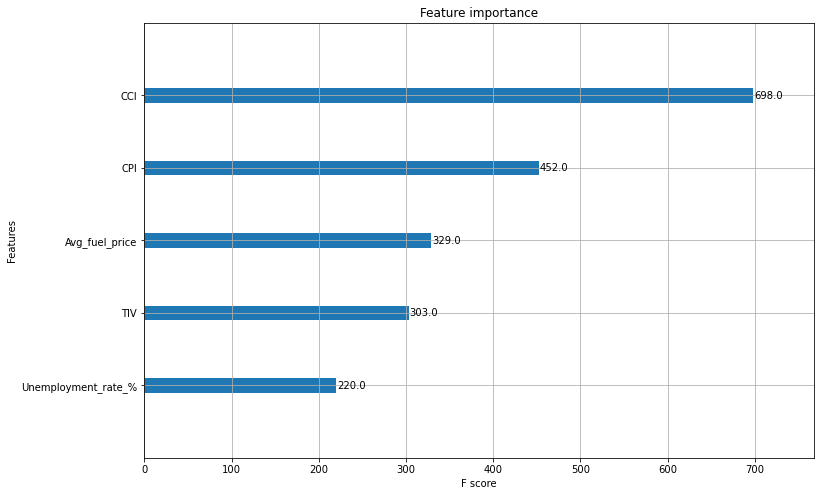

In [61]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)
plt.show();

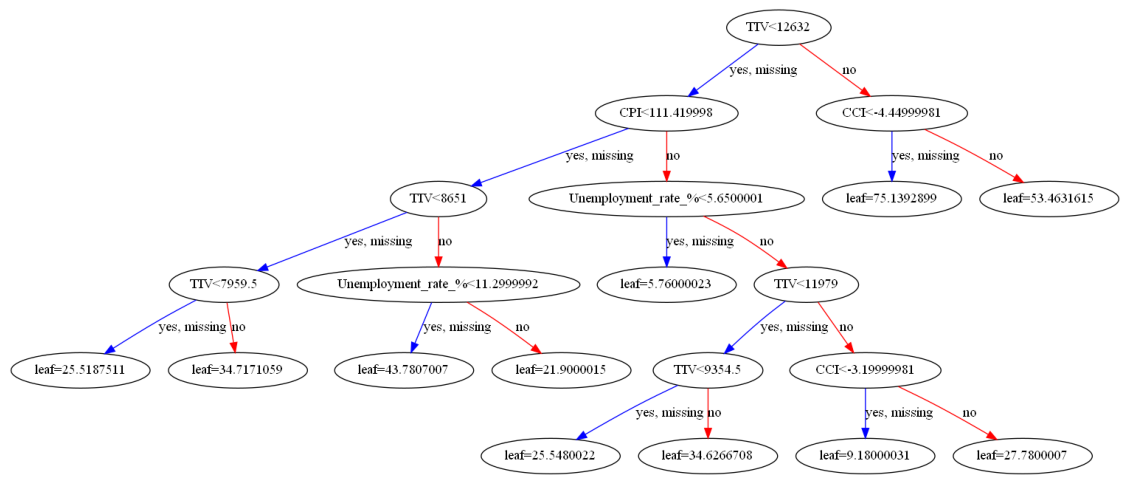

In [62]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax)
plt.show()

In [14]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

#### Hyperparameters Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
xgb_n_estimators = [100, 500, 1000]
xgb_max_depth = [4, 6, 8, 10]
xgb_min_child_weight = [1, 3, 5 , 7]
xgb_eta = [0.001, 0.01, 0.1, 0.2, 0.3]
xgb_subsample = [0.9, 0.5, 0.2, 0.1]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
param_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'eta': xgb_eta,
            'subsample': xgb_subsample,
            'objective': xgb_objective}

# Tune the Model
model_base = XGBRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1920 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 2212 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 3312 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4612 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  2.6min finished


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

 The best score across ALL searched params:
 0.10454305561834079

 The best parameters across ALL searched params:
 {'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 1000, 'objective': 'reg:squarederror

#### Tuned Model

XGBRegressor Tuned
XGBRegressor Tuned Model Performance:
Mean Absolute Error: 0.4238.
Mean Squared Error: 0.2653.
Root Mean Squared Error: 0.5151.
R^2 Score = -1.5506.
Mean Squared Log Error: 0.0060.
Root Mean Squared Log Error: 0.0774.
Mean Absolute Percentage Error: 7.8274.
Accuracy = 92.17%.


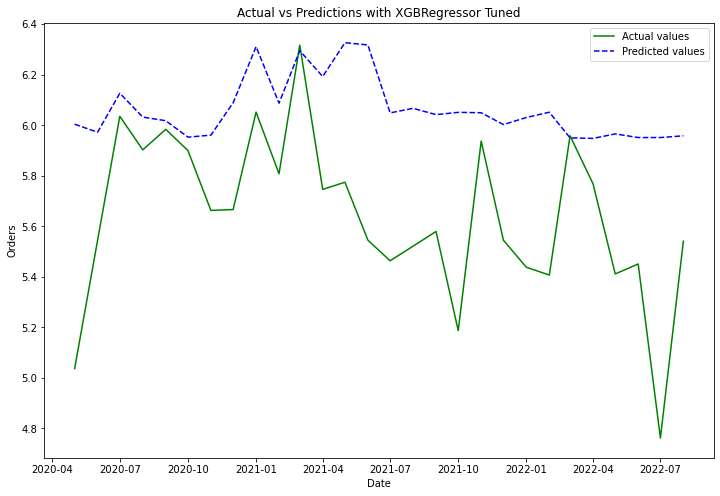

In [16]:
# Create the fnal Extreme Gradient Booster
model_tuned = XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 1000,
                         min_child_weight = 7,
                         max_depth = 4,                         
                         subsample = 0.2,
                         eta = 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

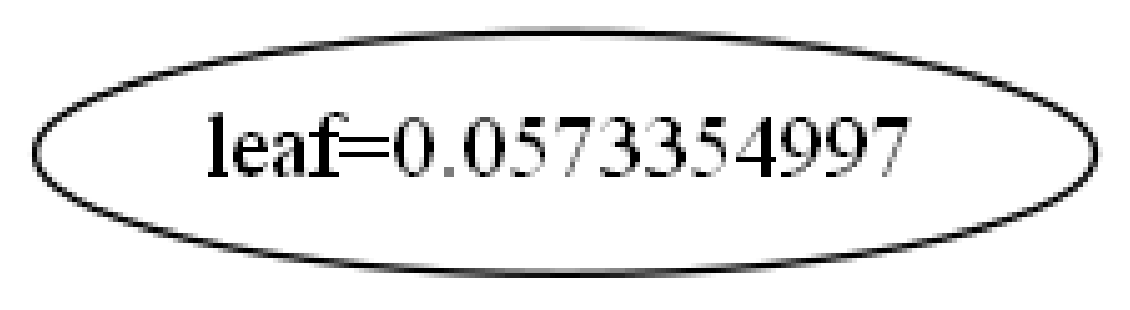

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model_tuned, ax=ax)
plt.show()

### LightGBM Regression

#### Baseline

LigthGBM version: 3.3.4
LGBMRegressor Model Performance:
Mean Absolute Error: 128.5141.
Mean Squared Error: 22210.2276.
Root Mean Squared Error: 149.0310.
R^2 Score = -1.6572.
Mean Squared Log Error: 0.2326.
Root Mean Squared Log Error: 0.4823.
Mean Absolute Percentage Error: 54.8565.
Accuracy = 45.14%.


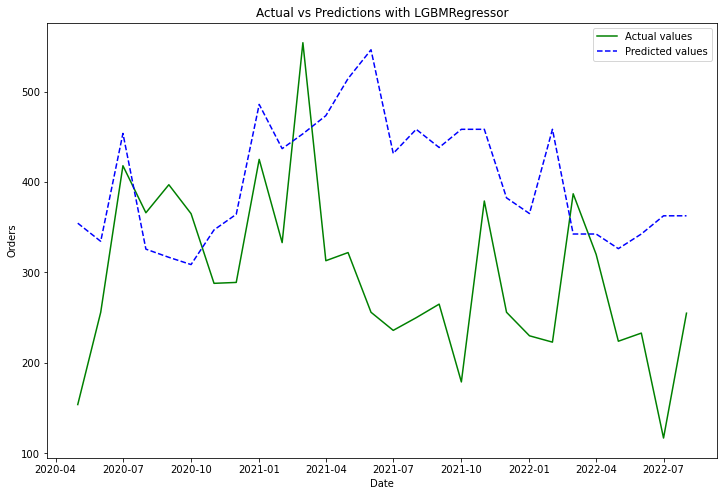

In [65]:
import lightgbm as lgbm

# Check ligthGBM version
print("LigthGBM version:", lgbm.__version__)

# Import LightGBM Regressor
from lightgbm import LGBMRegressor
          
# Instantiate the regressor
model = LGBMRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [66]:
model

LGBMRegressor(random_state=42)

#### Hyperparameters Tuning

In [67]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [100, 500, 1000]
lgbm_max_depth = [4, 6, 8, 10]
lgbm_num_leaves = [1, 3, 5 , 7]
lgbm_learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
lgbm_subsample = [0.9, 0.5, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

# Tune the Model
model_base = LGBMRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:   44.9s


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, num_leaves=5,
              random_state=42, subsample=0.0001)

 The best score across ALL searched params:
 0.07812989107779716

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5, 'subsample': 0.0001}


[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   45.8s finished


#### Tuned Model

LGBMRegressor Tuned
LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 137.9974.
Mean Squared Error: 26259.6819.
Root Mean Squared Error: 162.0484.
R^2 Score = -2.1417.
Mean Squared Log Error: 0.2686.
Root Mean Squared Log Error: 0.5183.
Mean Absolute Percentage Error: 60.3085.
Accuracy = 39.69%.


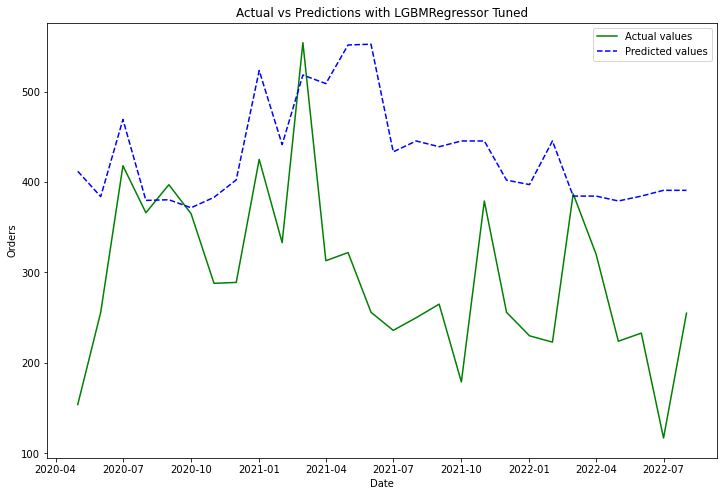

In [68]:
# Create the fnal LightGBM Model
model_tuned = LGBMRegressor(n_estimators = 500,
                         num_leaves= 5,
                         max_depth = 4,                         
                         subsample = 0.0001,
                         learning_rate= 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### Random Forest Regression

#### Baseline

RandomForestRegressor Model Performance:
Mean Absolute Error: 145.1639.
Mean Squared Error: 26377.5928.
Root Mean Squared Error: 162.4118.
R^2 Score = -2.1558.
Mean Squared Log Error: 0.2627.
Root Mean Squared Log Error: 0.5125.
Mean Absolute Percentage Error: 61.0253.
Accuracy = 38.97%.


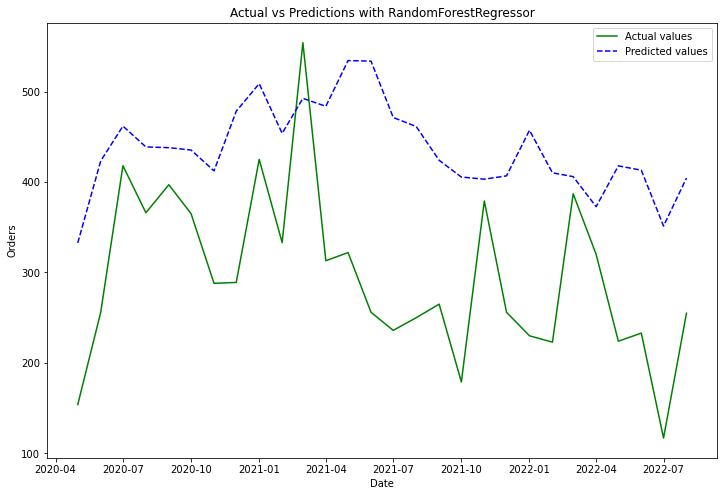

In [69]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
          
# Instantiate the regressor
model = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [70]:
model

RandomForestRegressor(random_state=42)

#### Hyperparameters Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning 
rf_n_estimators = [100, 500, 1000]
rf_max_depth = [4, 6, 8, 10]
rf_max_features = ['auto', 'sqrt']
rf_min_samples_leaf = [1, 2, 4]
rf_min_samples_split = [2, 5, 10]
rf_bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'max_features': rf_max_features,
           'min_samples_leaf': rf_min_samples_leaf,
           'min_samples_split': rf_min_samples_split,
           'bootstrap': rf_bootstrap
        }

# Tune the Model
model_base = RandomForestRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

 The best score across ALL searched params:
 0.028845345356432683

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  4.0min finished


#### Tuned Model

RandomForestRegressor Tuned
RandomForestRegressor Tuned Model Performance:
Mean Absolute Error: 150.5736.
Mean Squared Error: 28557.8136.
Root Mean Squared Error: 168.9906.
R^2 Score = -2.4167.
Mean Squared Log Error: 0.2876.
Root Mean Squared Log Error: 0.5363.
Mean Absolute Percentage Error: 64.6067.
Accuracy = 35.39%.


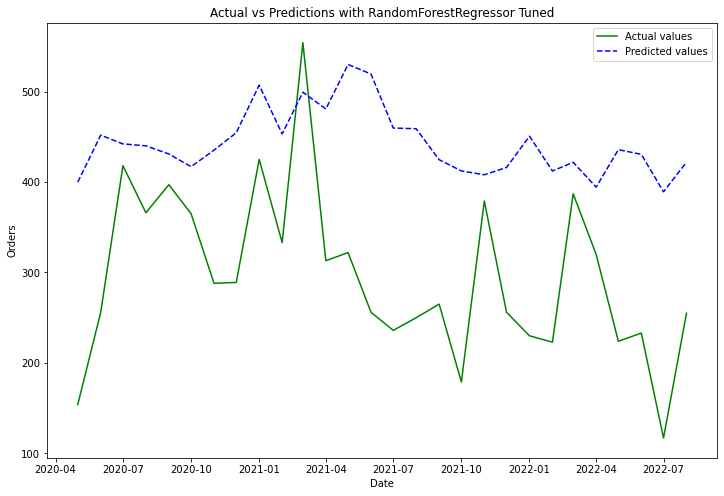

In [72]:
# Create the fnal Random Forest Regressor Model
model_tuned = RandomForestRegressor(n_estimators = 100,
                         max_depth = 8,                         
                         max_features = 'auto',
                         min_samples_leaf= 2,
                         min_samples_split = 10,
                         bootstrap = True,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

## Summary

In [73]:
metrics

XGBRegressor  XGBRegressor Tuned  \
Mean Absolute Error               110.201332          157.115278   
Mean Squared Error              17548.644245        31778.883339   
Root Mean Squared Error           132.471296          178.266327   
R^2                                -1.099534           -2.802051   
Mean Squared Log Error              0.185415            0.307903   
Root Mean Squared Log Error         0.430598            0.554890   
Mean Absolute Percentage Error     46.729228           67.692136   
Accuracy                           53.270772           32.307864   

                                LGBMRegressor  LGBMRegressor Tuned  \
Mean Absolute Error                128.514080           137.997399   
Mean Squared Error               22210.227609         26259.681917   
Root Mean Squared Error            149.030962           162.048394   
R^2                                 -1.657250            -2.141730   
Mean Squared Log Error               0.232637             0.268632   
Root Mean Squared Log Error          0.482324             0.518297   
Mean Absolute Percentage Error      54.856525            60.308521   
Accuracy                            45.143475            39.691479   

                                RandomForestRegressor  \
Mean Absolute Error                        145.163929   
Mean Squared Error                       26377.592846   
Root Mean Squared Error                    162.411800   
R^2                                         -2.155837   
Mean Squared Log Error                       0.262700   
Root Mean Squared Log Error                  0.512543   
Mean Absolute Percentage Error              61.025307   
Accuracy                                    38.974693   

                                RandomForestRegressor Tuned  
Mean Absolute Error                              150.573636  
Mean Squared Error                             28557.813619  
Root Mean Squared Error                          168.990573  
R^2                                               -2.416680  
Mean Squared Log Error                             0.287633  
Root Mean Squared Log Error                        0.536314  
Mean Absolute Percentage Error                    64.606669  
Accuracy                                          35.393331

# Other tests

### XGBoost (Extreme Gradient Boosting)

In [12]:
import xgboost as xgb
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring(xgb, X_test, y_test)

Model Performance
Mean Absolute Error: 110.2013.
Mean Squared Error: 17548.6442.
R^2 Score = -1.0995.
Accuracy = 53.27%.


In [13]:
xgb.feature_importances_

array([0.06292622, 0.19028747, 0.        , 0.08134924, 0.32268733,
       0.18839407, 0.07928713, 0.05888204, 0.0161865 ], dtype=float32)

In [14]:
xgb.plot_importance(xgb_regressor, ax=plt.gca())

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

### Cross-validation

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Create the models to be tested
mlgbm = lgbm.LGBMRegressor()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

models = [mlgbm, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

In [16]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold'])

r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)

r2_comp

1st Fold  2nd Fold  \
LGBMRegressor()                                       0.8006    0.7286   
RandomForestRegressor(random_state=42)                0.9872    0.9921   
XGBRegressor(base_score=None, booster=None, cal...    0.9935    0.9896   

                                                    3rd Fold  4th Fold  \
LGBMRegressor()                                       0.8202    0.8027   
RandomForestRegressor(random_state=42)                0.9889    0.9521   
XGBRegressor(base_score=None, booster=None, cal...    0.9944    0.9765   

                                                    Average  
LGBMRegressor()                                      0.7880  
RandomForestRegressor(random_state=42)               0.9801  
XGBRegressor(base_score=None, booster=None, cal...   0.9885

### Hyperparameters Tuning - Random Forest

In [17]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'absolute_error']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'absolute_error'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=35,
                      min_impurity_decrease=0.1, min_samples_split=4,
                      n_estimators=600)

### Hyperparameters Tuning - XGBoost (Extreme Gradient Boosting)

In [19]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist'
]
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'tree_method': 'auto',
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 6,
 'gamma': 0,
 'eta': 0.30000000000000004}

### Final Evaluation

In [20]:
# Create the final LigthGBM

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.1,
                                 max_features = 'sqrt',
                                 max_depth = 35,
                                 criterion = 'absolute_error',
                                 bootstrap = False,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'auto',
                         objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight = 2,
                         max_depth = 6,
                         gamma = 0,
                         eta = 0.3,
                         random_state = 42)

# Train the models using 80% of the original data
# LGBM goes here --
rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores
    
# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

### XGBoost (Extreme Gradient Boosting)

In [20]:
import xgboost as xgb

# check xgboost version
print(xgb.__version__)

# Select input and target variables
X = data.drop(['Orders'], axis=1)
y = data["Orders"]

# Create the DMatrix 
dmatrix = xgb.DMatrix(data=X, label=y)

# Definiing params
params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization
reg_params = [1,10,100]
rmses_l1=[]

for reg in reg_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(reg_params,rmses_l1)), columns=["l1","rmse"]))

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# L2 regularization
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

1.7.2
Best rmse as a function of l1:
    l1        rmse
0    1  141.909760
1   10  142.030444
2  100  149.481071
Best rmse as a function of l2:
    l2        rmse
0    1  184.852129
1   10  210.660478
2  100  351.448666


In [118]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9,rankdir="LR")
plt.show()

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'train'

### Model tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                    'n_estimators': [200],
                    'subsample': np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.05}
Lowest RMSE found:  181.18036412771912


In [28]:
# Create the DMatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds        rmse
0                    5  183.122624
1                   10  147.596829
2                   15  145.746563


In [21]:
X_train.shape, X_test.shape

((112, 13), (28, 13))

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 72.653859


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [33]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       368.897880       12.618361      368.081924      28.865079
1       337.347801       11.430440      337.864388      30.209572
2       308.618192       10.960824      309.358712      31.367627
3       282.799589       10.193485      283.653487      32.242495
4       259.745429        9.594686      261.709599      32.982860

In [34]:
print((cv_results["test-rmse-mean"]).tail(1))

32    115.488021
Name: test-rmse-mean, dtype: float64


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [22]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_tree'

In [119]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

## Choosing classifier

In [120]:
from xgboost import XGBRegressor
import xgboost as xgb
#create an xgboost regression model
model = XGBRegressor()

## Fitting the model

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

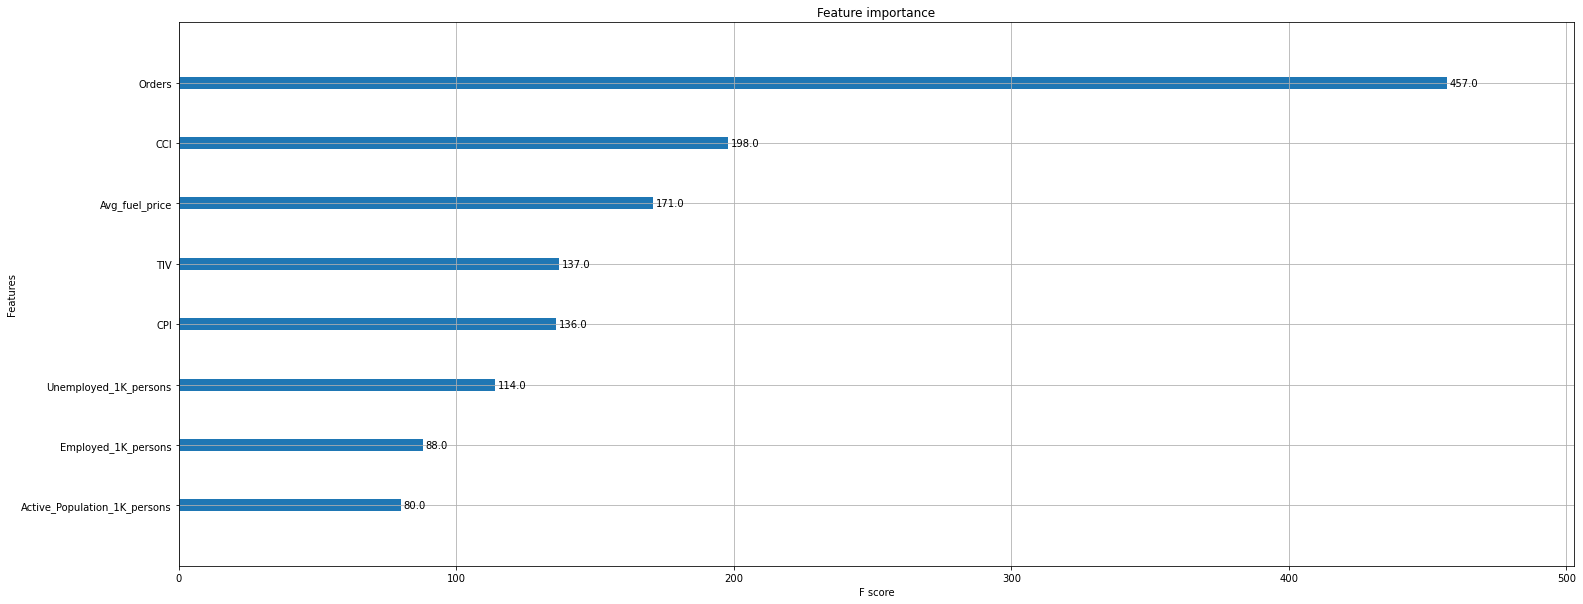

In [122]:
xgb.plot_importance(model, ax=plt.gca())

## Tuning hyperparameters

In [ ]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [26]:
# evaluate an xgboost regression model 
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# split data into input and output columns
X, y = datavalues[:, :-1], datavalues[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 20.692 (7.774)


In [51]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [52]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', \
                           n_estimators=1000, \
                          nthread=24)
reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', ...)

In [53]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 68.086
